<a id='top'></a>
# Reproduce Plots in the Final Version of the Paper
This noteboook will load the data files made available with the paper, and generate the plots as they are in the final version of the submission.

Plots available:

1. [Followers](#followers)
1. [Bot score of connections](#botscore)
1. [Exposure to echo chamber](#echo_chamber)
1. [Exposure to low credibity content](#misinformation)
1. [Home timeline drift](#home_timeline)
1. [User timeline drift](#user_timeline)
1. [Algorithmic bias](#bias)
1. [Information Correlation](#correlation)

In [21]:
# imports
%load_ext autoreload
%autoreload 2

import os
# import sys
# sys.path.insert(1, './')
import plot_helper as plt_helper
# from collections import OrderedDict
import pandas as pd
import numpy as np
from datetime import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import dates
import statsmodels.formula.api as smf
# import json
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.MatplotlibDeprecationWarning)

In [3]:
plt.rcParams.update({'font.size': 20})

DATA_PATH = "../data/"
OUTPUT_PATH = "./images_out/"

[back to top](#top) <a id='followers'></a>
## Followers           
The evolution of the number of followers.

In [4]:
# load followers data
followers_df = pd.read_csv(os.path.join(DATA_PATH,"followers_data.csv"),index_col=0)
followers_df.index = pd.to_datetime(followers_df.index)
followers_df.head(2)

,bot11,bot14,bot12,bot13,bot10,bot7,bot2,bot5,bot6,bot15,bot1,bot4,bot3,bot8,bot9
date,,,,,,,,,,,,,,,
2019-07-13,1.0,NaN,1.0,3.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,2.0,1.0,1.0,NaN
2019-07-14,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


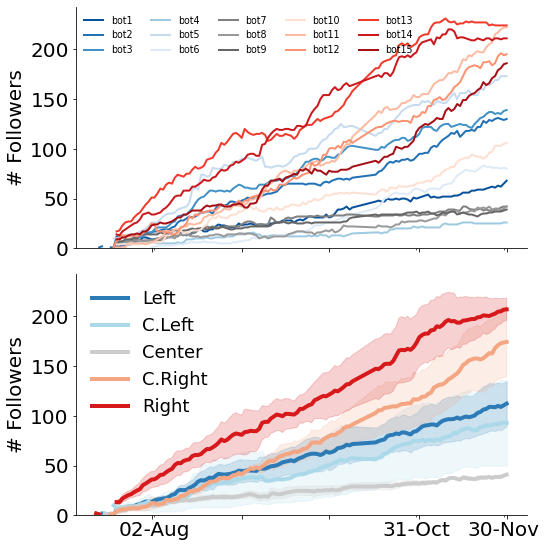

In [5]:
plt_helper.plot_bots_and_summary(
    bots_df=followers_df[followers_df.index<dt(2019,12,2)], 
    y_label="# Followers", 
    bots_legend_loc=None,
    filename=os.path.join(OUTPUT_PATH,"followers.pdf"),
    minor_locator = dates.DayLocator(interval=30),
    sem=True,
#     major_formatter = dates.DateFormatter('%d-%b'),
    figsize=(8,8),
    ncol_main_plot=1,
    leg_size_main_plot=18,
    confidence_interval = 1,
    group_legend=["Left","C.Left", "Center", "C.Right", "Right"]
)

## Significance Test

Load and format the data

In [6]:
followers_df = pd.read_csv(os.path.join(DATA_PATH,"followers_data.csv"), parse_dates=['date'])
followers_df = followers_df[followers_df.date < pd.to_datetime('2019-12-2')].copy()
followers_df['delta_day'] = (followers_df.date - pd.to_datetime('2019-07-13')).dt.days

In [7]:
bot_group = {
    'left': [1, 2, 3],
    'cleft': [4, 5, 6],
    'center': [7, 8, 9],
    'cright': [10, 11, 12],
    'right': [13, 14, 15]
}
group_list = ['left', 'cleft', 'center', 'cright', 'right']

The goal here is to perform statistical tests to demonstrate the certain groups of drifters gain followers faster than other groups.

Here we mainly focus on the pairs: left vs. center, right vs. center, and right vs. left.

There are multiple ways to test whether the drifters in one groups gain followers significantly faster than those in another group.
We present the results from three different approaches to demonstrate the robustness of our results.

**Daily increase in followers**

First, we focus on the daily follower growth for each drifter bot. We record the follower count on a daily basis in our experiment, with a few exceptions due to technical issues. We calculate the daily growth rate for any two consecutive observations of the follower count. We then combine the data points from each group and use t-tests to compare different groups.

In [8]:
bot_time_series = {}
daily_increments = {}
for n in range(1, 16):
    temp_df = followers_df[[f'bot{n}', 'delta_day']].dropna()
    
    temp_df_diff = temp_df.diff().dropna()
    daily_increment = temp_df_diff[f'bot{n}'] / temp_df_diff['delta_day']
    
    bot_time_series[n] = temp_df.rename(columns={f'bot{n}': 'n_follower'})
    daily_increments[n] = daily_increment

In [9]:
daily_increments_group = {}
for group, bot_list in bot_group.items():
    group_daily_increment = []
    for bot_id in bot_list:
        group_daily_increment.extend(daily_increments[bot_id])
    daily_increments_group[group] = group_daily_increment

In [45]:
for group, data in daily_increments_group.items():
    print(group, len(data))

left 387
cleft 373
center 389
cright 387
right 386


In [42]:
# Left vs. center
t_stat, pvalue  = stats.ttest_ind(
    daily_increments_group['left'],
    daily_increments_group['center'],
    alternative="greater"
)
print(f"T stat: {t_stat:0.3f}, p value: {pvalue:0.3f}")

T stat: 5.137, p value: 0.000


In [46]:
# Right vs. center
t_stat, pvalue  = stats.ttest_ind(
    daily_increments_group['right'],
    daily_increments_group['center'],
    alternative="greater"
)
print(f"T stat: {t_stat:0.3f}, p value: {pvalue:0.3f}")

T stat: 7.965, p value: 0.000


In [43]:
# Right vs. left
t_stat, pvalue  = stats.ttest_ind(
    daily_increments_group['right'],
    daily_increments_group['left'],
    alternative="greater"
)
print(f"T stat: {t_stat:0.3f}, p value: {pvalue:0.3f}")

T stat: 3.842, p value: 0.000


We can see that drifters in both left and right group gain followers significantly faster than those in the center group; drifters from the right group gain followers significantly faster than those in the left group.

**Nested approach**

we use linear regression to estimate the follower growth rate for each drifter. We then use a t-test to compare the estimated growth rates of two different groups.

In [22]:
nested_results = {}
for group_id in group_list:
    nested_results_inner_loop = []
    for bot_id in bot_group[group_id]:
        temp_df = bot_time_series[bot_id]
        model = smf.ols('n_follower ~ delta_day - 1', temp_df).fit()
        nested_results_inner_loop.append(model.params[0])
    nested_results[group_id] = nested_results_inner_loop

In [40]:
# Left vs. center
t_stat, pvalue = stats.ttest_ind(
    nested_results['left'],
    nested_results['center'],
    alternative="greater"
)
print(f"T stat: {t_stat:0.3f}, p value: {pvalue:0.3f}")

T stat: 2.706, p value: 0.027


In [47]:
# Right vs. center
t_stat, pvalue = stats.ttest_ind(
    nested_results['right'],
    nested_results['center'],
    alternative="greater"
)
print(f"T stat: {t_stat:0.3f}, p value: {pvalue:0.3f}")

T stat: 5.434, p value: 0.003


In [41]:
# Right vs. left
t_stat, pvalue = stats.ttest_ind(
    nested_results['right'],
    nested_results['left'],
    alternative="greater"
)
print(f"T stat: {t_stat:0.3f}, p value: {pvalue:0.3f}")

T stat: 2.599, p value: 0.030


We can see that the findings are consistent with the first approach.

**Interaction approach**

We first combine the raw observations (follower-date pairs) from the drifters within the same group and then combine them across two groups to be compared, using a dummy variable `ref` to distinguish them. Finally we apply linear regression to this combined data set with an extra interaction term between elapsed time and the dummy variable. The coefficient of the interaction term indicates whether the growth rates between the two groups are significantly differen

In [32]:
group_raw_dfs = {}
for group_id in group_list:
    temp_list = []
    for bot_id in bot_group[group_id]:
        temp_list.append(bot_time_series[bot_id])
    temp_df = pd.concat(temp_list)
    group_raw_dfs[group_id] = temp_df

In [35]:
# Left vs. center
group_left = group_raw_dfs['left'].copy()
group_center = group_raw_dfs['center'].copy()
group_left['ref'] = 1
group_center['ref'] = 0
full_df = pd.concat([group_left, group_center])
model = smf.ols('n_follower ~ delta_day + ref + delta_day * ref - 1', full_df).fit()
        
coef = model.params['delta_day:ref']
pvalue = model.pvalues['delta_day:ref']
print(f"Coef of the interaction term: {coef:0.3f}, p value: {pvalue:0.3f}")

Coef of the interaction term: 0.464, p value: 0.000


In [61]:
len(group_raw_dfs['left']) + len(group_raw_dfs['center'])

782

In [48]:
# Right vs. center
group_right = group_raw_dfs['right'].copy()
group_center = group_raw_dfs['center'].copy()
group_right['ref'] = 1
group_center['ref'] = 0
full_df = pd.concat([group_right, group_center])
model = smf.ols('n_follower ~ delta_day + ref + delta_day * ref - 1', full_df).fit()
        
coef = model.params['delta_day:ref']
pvalue = model.pvalues['delta_day:ref']
print(f"Coef of the interaction term: {coef:0.3f}, p value: {pvalue:0.3f}")

Coef of the interaction term: 1.176, p value: 0.000


In [62]:
len(group_raw_dfs['right']) + len(group_raw_dfs['center'])

781

In [36]:
# Right vs. left
group_right = group_raw_dfs['right'].copy()
group_left = group_raw_dfs['left'].copy()
group_right['ref'] = 1
group_left['ref'] = 0
full_df = pd.concat([group_right, group_left])
model = smf.ols('n_follower ~ delta_day + ref + delta_day * ref - 1', full_df).fit()
        
coef = model.params['delta_day:ref']
pvalue = model.pvalues['delta_day:ref']
print(f"Coef of the interaction term: {coef:0.3f}, p value: {pvalue:0.3f}")

Coef of the interaction term: 0.686, p value: 0.000


In [63]:
len(group_raw_dfs['right']) + len(group_raw_dfs['left'])

779

We can see that the findings are consistent with the other two approaches.

[back to top](#top) 
<a id='botscore'></a>
## Bot Score           
Bot score comparision among friends and followers of our accounts.

In [187]:
bot_score_summary = pd.read_csv(
    os.path.join(DATA_PATH,"connections_seeds_unique_botscores.csv"),
    index_col=[0,1]
)
bot_score_summary = bot_score_summary.bot_scores.apply(eval)
bot_score_summary

conn_type  seed        
follower   Center          [0.3039573320934062, 0.8701191997119831, 0.400...
           Center-left     [0.1167953743919475, 0.05780718298413593, 0.04...
           Center-right    [0.16847316644464133, 0.12588928944948308, 0.4...
           Left            [0.380551857066998, 0.8701191997119831, 0.6109...
           Right           [0.15685510336103622, 0.19374947883382485, 0.7...
friend     Center          [0.04178983547133819, 0.038503444945083086, 0....
           Center-left     [0.25265321740844954, 0.03265990956683609, 0.1...
           Center-right    [0.08592399976334196, 0.04918384795249982, 0.8...
           Left            [0.6698271269837389, 0.7719542327261165, 0.038...
           Right           [0.04918384795249982, 0.027677698437753848, 0....
Name: bot_scores, dtype: object

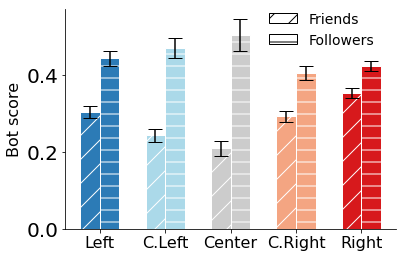

In [204]:
plt_helper.plotTwoBarsPlot(
    bars1 = bot_score_summary.loc[("friend")].loc[plt_helper.INIT_SEED_RENAME.values()].apply(lambda x: pd.Series(x).mean()),
    bars2 = bot_score_summary.loc[("follower")].loc[plt_helper.INIT_SEED_RENAME.values()].apply(lambda x: pd.Series(x).mean()),
    yer1 = bot_score_summary.loc[("friend")].loc[plt_helper.INIT_SEED_RENAME.values()].apply(lambda x: pd.Series(x).sem()),
    yer2 = bot_score_summary.loc[("follower")].loc[plt_helper.INIT_SEED_RENAME.values()].apply(lambda x: pd.Series(x).sem()),
    colors = [plt_helper.ACCOUNT_COLORS[k] for k in plt_helper.INIT_SEED_RENAME.values()], 
    xticks=['Left', 'C.Left', 'Center', 'C.Right', 'Right'], 
    figname=os.path.join(OUTPUT_PATH,"connections_botscore-combined.pdf"),
    legend_loc=(.6,.8)
);

### Significance Test

In [227]:
pairs_to_compare =[
    ("Center","Center-right","friend"),
    ("Center","Right","friend"),
    ("Center-right","Right","friend"),
    
    ("Center","Center-left","friend"),
    ("Center","Left","friend"),
    ("Center-left","Left","friend"),

    ("Left","Right","friend"),

    ("Right","Left","follower"),
    ("Right","Center","follower"),
    ("Center-right","Center","follower"),
    ("Left","Center","follower"),
    ("Center-left","Center","follower"),

]
for pair in pairs_to_compare:
    set1 = bot_score_summary.loc[(pair[2],pair[0])]
    set2 = bot_score_summary.loc[(pair[2],pair[1])]
    res = stats.ttest_ind(
        set1,
        set2,
        alternative='less'
    )
    print("{}{} - {} (n={}) is less than {} (n={}) (t={:.2f}, p={:.4f})".format(
        "***" if res[1]<=.01 else ("**" if res[1]<=.05 else ""),
        pair[2], pair[0], len(set1), pair[1], len(set2), res[0], res[1]
    ))


***friend - Center (n=206) is less than Center-right (n=323) (t=-3.31, p=0.0005)
***friend - Center (n=206) is less than Right (n=414) (t=-6.14, p=0.0000)
***friend - Center-right (n=323) is less than Right (n=414) (t=-3.01, p=0.0013)
friend - Center (n=206) is less than Center-left (n=261) (t=-1.29, p=0.0994)
***friend - Center (n=206) is less than Left (n=282) (t=-3.67, p=0.0001)
***friend - Center-left (n=261) is less than Left (n=282) (t=-2.56, p=0.0054)
***friend - Left (n=282) is less than Right (n=414) (t=-2.33, p=0.0099)
follower - Right (n=299) is less than Left (n=172) (t=-0.84, p=0.2019)
**follower - Right (n=299) is less than Center (n=65) (t=-2.30, p=0.0110)
***follower - Center-right (n=205) is less than Center (n=65) (t=-2.48, p=0.0069)
follower - Left (n=172) is less than Center (n=65) (t=-1.47, p=0.0717)
follower - Center-left (n=118) is less than Center (n=65) (t=-0.73, p=0.2332)


[back to top](#top) <a id='echo_chamber'></a>
## Echo Chamber           
Estimating exposure to echo chamber via density and clusterig coeficient measurements.

In [130]:
# load dataframe
echo_chamber_df = pd.read_csv(
    os.path.join(DATA_PATH, "echo_chamber_data.csv"),
    index_col=[0,1]
)
echo_chamber_df.info()
echo_chamber_df.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 36 entries, ('avg_clus', 'mean') to ('trans_rand_norm', 'raw_values')
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Left          36 non-null     object
 1   Center-left   36 non-null     object
 2   Center        36 non-null     object
 3   Center-right  36 non-null     object
 4   Right         36 non-null     object
dtypes: object(5)
memory usage: 2.0+ KB


Left  \
avg_clus      mean                                       0.5638353114423187   
              sem                                      0.020577138190557287   
              raw_values  [0.539778137378471, 0.5469468597187582, 0.6047...   
avg_clus_rand mean                                      0.21091124938947045   
              sem                                      0.009476614837861465   

                                                                Center-left  \
avg_clus      mean                                       0.5481060665905081   
              sem                                      0.041299811193296475   
              raw_values  [0.4712540808056241, 0.5603146525841776, 0.612...   
avg_clus_rand mean                                      0.20132661033226792   
              sem                                       0.02216317286748586   

                                                                     Center  \
avg_clus      mean                                       0.5630153887327252   
              sem                                      0.008027115985746888   
              raw_values  [0.547024152964747, 0.5697805363384861, 0.5722...   
avg_clus_rand mean                                      0.17762062990266572   
              sem                                      0.004332721831145718   

                                                               Center-right  \
avg_clus      mean                                       0.5733518857266166   
              sem                                       0.00872310812893434   
              raw_values  [0.5564587054566891, 0.5780244605511922, 0.585...   
avg_clus_rand mean                                       0.2760682859802807   
              sem                                      0.012232826418055601   

                                                                      Right  
avg_clus      mean                                       0.5771129655634665  
              sem                                      0.013674413500280565  
              raw_values  [0.5504738406762537, 0.5850718822752066, 0.595...  
avg_clus_rand mean                                      0.28405825574274407  
              sem                                      0.011457113930999244

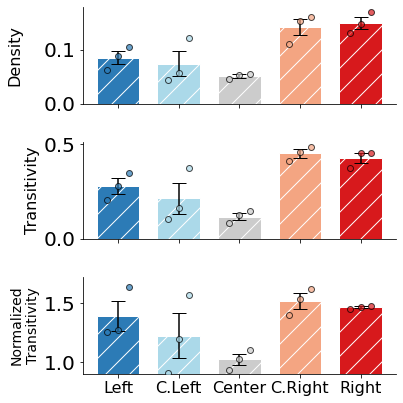

In [136]:
colors = [plt_helper.ACCOUNT_COLORS[k] for k in echo_chamber_df.columns]
fig, axs = plt.subplots(3,1, sharex=True,figsize=(6,6))

value_to_plot = "density"
plt_helper.plotTwoBarsPlot(
    bars1 = echo_chamber_df.loc[(value_to_plot,"mean")].astype("float"), 
    yer1 = echo_chamber_df.loc[(value_to_plot,"sem")].astype("float"), 
    colors = colors,
    xticks=['Left', 'C.Left', 'Center', 'C.Right', 'Right'], 
    saveFig=False,
#     figname=os.path.join(OUTPUT_PATH,"echo_chamber-density.pdf"),
    barWidth=0.7,
    ax=axs[0],
    ylabel="Density\n",
    scatter1 = echo_chamber_df.loc[(value_to_plot,"raw_values")].apply(eval)
)

value_to_plot = "trans"
plt_helper.plotTwoBarsPlot(
    bars1 = echo_chamber_df.loc[(value_to_plot,"mean")].astype("float"), 
    yer1 = echo_chamber_df.loc[(value_to_plot,"sem")].astype("float"), 
    colors = colors,
    xticks=['Left', 'C.Left', 'Center', 'C.Right', 'Right'], 
    saveFig=False,
#   figname=os.path.join(OUTPUT_PATH,"echo_chamber-transitivity.pdf"),
    barWidth=0.7,
    ax=axs[1],
    ylabel="Transitivity",
    scatter1 = echo_chamber_df.loc[(value_to_plot,"raw_values")].apply(eval)
)

value_to_plot = "trans_rand_norm"
plt_helper.plotTwoBarsPlot(
    bars1 = echo_chamber_df.loc[(value_to_plot,"mean")].astype("float"), 
    yer1 = echo_chamber_df.loc[(value_to_plot,"sem")].astype("float"), 
    colors = colors,
    xticks=['Left', 'C.Left', 'Center', 'C.Right', 'Right'], 
    saveFig=False,
#   figname=os.path.join(OUTPUT_PATH,"echo_chamber-normalized_transitivity.pdf"),
    barWidth=0.7,
    ax=axs[2],
    ylabel="Normalized\nTransitivity",
    ylabel_size=14,
    ylim=(.9),
    scatter1 = echo_chamber_df.loc[(value_to_plot,"raw_values")].apply(eval)
)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH,"echo_chamber.pdf"))

### Significance Test

In [226]:
pairs_to_compare =[
    ("Center","Center-right"),
    ("Center","Right"),
    ("Center-right","Right"),
    
    ("Center","Center-left"),
    ("Center","Left"),
    ("Center-left","Left"),
    
    ("Left","Right")
]
for value_to_plot in ["density", "trans", "trans_rand_norm"]:
    for pair in pairs_to_compare:
        set1 = echo_chamber_df.loc[(value_to_plot,"raw_values")].apply(eval)[pair[0]]
        set2 = echo_chamber_df.loc[(value_to_plot,"raw_values")].apply(eval)[pair[1]]
        res = stats.ttest_ind(
            set1,
            set2,
            alternative='less'
        )
        print("{}{} - {} (n={}) is less than {} (n={}) (t={:.2f}, p={:.4f})".format(
            "***" if res[1]<=.01 else ("**" if res[1]<=.05 else ""),
            value_to_plot, pair[0], len(set1), pair[1], len(set2), res[0], res[1]
        ))


***density - Center (n=3) is less than Center-right (n=3) (t=-5.82, p=0.0022)
***density - Center (n=3) is less than Right (n=3) (t=-8.28, p=0.0006)
density - Center-right (n=3) is less than Right (n=3) (t=-0.43, p=0.3446)
density - Center (n=3) is less than Center-left (n=3) (t=-0.97, p=0.1925)
**density - Center (n=3) is less than Left (n=3) (t=-2.68, p=0.0277)
density - Center-left (n=3) is less than Left (n=3) (t=-0.40, p=0.3532)
***density - Left (n=3) is less than Right (n=3) (t=-3.84, p=0.0092)
***trans - Center (n=3) is less than Center-right (n=3) (t=-11.31, p=0.0002)
***trans - Center (n=3) is less than Right (n=3) (t=-9.31, p=0.0004)
trans - Center-right (n=3) is less than Right (n=3) (t=0.68, p=0.7330)
trans - Center (n=3) is less than Center-left (n=3) (t=-1.15, p=0.1567)
**trans - Center (n=3) is less than Left (n=3) (t=-3.53, p=0.0121)
trans - Center-left (n=3) is less than Left (n=3) (t=-0.70, p=0.2602)
**trans - Left (n=3) is less than Right (n=3) (t=-3.02, p=0.0196)
*

[back to top](#top) <a id='misinformation'></a>
## Low Credibility
Measuring the exposure to misinformation using as proxy the exposure to URL domains of low credibility websites.

In [139]:
low_cred_summary = pd.read_csv(
    os.path.join(DATA_PATH,"low_credibility_summary_data.csv"),
    index_col=0, 
    header=[0, 1], 
    skipinitialspace=True
)
low_cred_summary

sum                                                    mean  \
                 sum        mean        sem             raw_values       sum   
seed                                                                           
Center         138.0   46.000000  19.502137     [10.0, 51.0, 77.0]  0.025390   
Center-left    182.0   60.666667  48.312639     [6.0, 19.0, 157.0]  0.029120   
Center-right  1081.0  360.333333  76.788309  [227.0, 361.0, 493.0]  0.234737   
Left           130.0   43.333333  29.356052    [12.0, 16.0, 102.0]  0.029125   
Right         1224.0  408.000000  69.615611  [290.0, 403.0, 531.0]  0.379797   

                                  \
                  mean       sem   
seed                               
Center        0.008463  0.003319   
Center-left   0.009707  0.007262   
Center-right  0.078246  0.009148   
Left          0.009708  0.008465   
Right         0.126599  0.002734   

                                                                 count  \
                                                     raw_values    sum   
seed                                                                     
Center        [0.003198976327575176, 0.0075938058368076235, ...  15117   
Center-left   [0.001784121320249777, 0.003126542701991114, 0...  15925   
Center-right  [0.0650802752293578, 0.07382449835280024, 0.09...  13933   
Left          [0.0011705033164260631, 0.001315681276210838, ...  26242   
Right         [0.12189957652752571, 0.12652705061082026, 0.1...   9640   

                                                              
                     mean          sem            raw_values  
seed                                                          
Center        5039.000000  1043.039948    [3126, 5275, 6716]  
Center-left   5308.333333   979.771629    [3363, 6077, 6485]  
Center-right  4644.333333  1020.018028    [3488, 3767, 6678]  
Left          8747.333333  2520.156895  [3829, 10252, 12161]  
Right         3213.333333   507.301795    [2292, 3306, 4042]

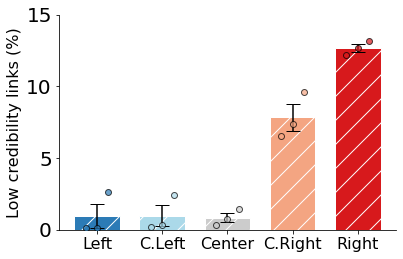

In [154]:
ax = plt_helper.plotTwoBarsPlot(
    bars1 = low_cred_summary.loc[plt_helper.INIT_SEED_RENAME.values(),("mean","mean")]*100, 
    yer1 = low_cred_summary.loc[plt_helper.INIT_SEED_RENAME.values(),("mean","sem")]*100, 
    colors = [plt_helper.ACCOUNT_COLORS[k] for k in plt_helper.INIT_SEED_RENAME.values()], 
    xticks=['Left', 'C.Left', 'Center', 'C.Right', 'Right'], 
    figname=os.path.join(OUTPUT_PATH,"low_credibility_no_breitbart-low_cred_urls_mean.pdf"),
    barWidth=0.7,
    ylabel="Low credibility links (%)",
    ylim=(0,15),
    scatter1 = low_cred_summary.loc[plt_helper.INIT_SEED_RENAME.values(),("mean","raw_values")].apply(
        lambda x: [mu*100 for mu in eval(x)]
    )
);

### Significance Test

In [231]:
pairs_to_compare =[
    ("Right","Center-right"),
    ("Right","Center"),
    ("Right","Center-left"),
    ("Right","Left"),
]
for pair in pairs_to_compare:
    set1 = eval(low_cred_summary.loc[pair[0],("mean","raw_values")])
    set2 = eval(low_cred_summary.loc[pair[1],("mean","raw_values")])
    res = stats.ttest_ind(
        set1,
        set2,
        alternative='greater'
    )
    print("{}{} (n={}) is greater than {} (n={}) (t={:.2f}, p={:.4f})".format(
        "***" if res[1]<=.01 else ("**" if res[1]<=.05 else ""),
        pair[0], len(set1), pair[1], len(set2), res[0], res[1]
    ))


***Right (n=3) is greater than Center-right (n=3) (t=5.06, p=0.0036)
***Right (n=3) is greater than Center (n=3) (t=27.47, p=0.0000)
***Right (n=3) is greater than Center-left (n=3) (t=15.06, p=0.0001)
***Right (n=3) is greater than Left (n=3) (t=13.14, p=0.0001)


[back to top](#top) <a id='home_timeline'></a>
## Home Timeline Drift           
The political alignment score over time based on the content (URL and hashtag) **presented to** our accounts home timeline.

In [17]:
summary_results = []

In [18]:
def get_central_score(medium):
    return plt_helper.USATODAY_HASHTAG_SCORE if medium == "hashtag" else plt_helper.SEED_URL_SCORE.get("USATODAY")

In [19]:
loc= "home"

### Based on URL scores

In [20]:
medium = "url"
home_tl_df = plt_helper.load_data(
    medium, 
    loc, 
    center_score= get_central_score(medium), 
    basepath= os.path.join(DATA_PATH,"time_series/")
)
home_tl_df.head(2)

/nfs/nfs7/home/pacheco/code/DrifterBot/exps/plot_helper.py:289: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['bot%s%s' % (bot_idx, stat)] = tmp_df['bot%s%s' % (bot_idx, stat)].fillna(method='ffill')
/nfs/nfs7/home/pacheco/code/DrifterBot/exps/plot_helper.py:290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['bot%s%s' % (bot_idx, stat)] = tmp_df['bot%s%s' % (bot_idx, stat)].fillna(method='bfill')


,bot1,bot1_var,bot1_count,bot1_sem,bot2,bot2_var,bot2_count,bot2_sem,bot3,bot3_var,...,bot13_count,bot13_sem,bot14,bot14_var,bot14_count,bot14_sem,bot15,bot15_var,bot15_count,bot15_sem
date,,,,,,,,,,,,,,,,,,,,,
2019-07-10,-0.343267,0.133263,6,0.149032,-0.44025,0.055697,1,0.063074,0.029300,0.047932,...,1.0,0.041508,0.303400,0.023706,1.0,0.051323,0.303400,0.040245,1,0.051797
2019-07-11,-0.331907,0.068372,15,0.067514,-0.29935,0.055697,14,0.063074,-0.392267,0.047932,...,31.0,0.041508,0.321333,0.023706,9.0,0.051323,0.401093,0.040245,15,0.051797


In [21]:
summary_results.append(("{}-{}".format(loc,medium),home_tl_df))

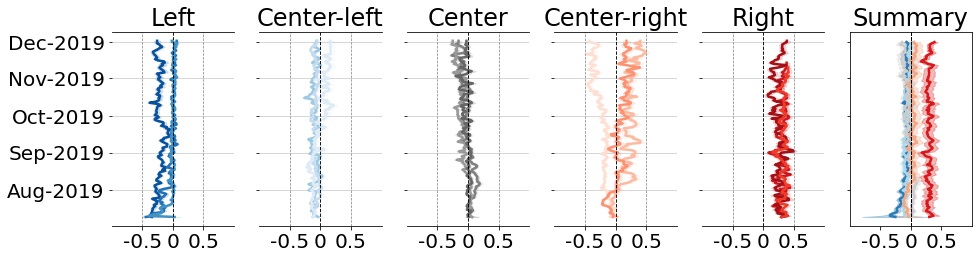

In [22]:
plt_helper.plot_vertical_scores(
    home_tl_df, 
    summary_xlim=[-1,1], 
    xlabel="",
    filename=os.path.join(OUTPUT_PATH,"timeline_{}_{}.pdf".format(loc,medium))
);

### Based on HASHTAG scores

In [23]:
medium = "hashtag"
home_tl_df = plt_helper.load_data(
    medium, 
    loc, 
    center_score=get_central_score(medium), 
    basepath= os.path.join(DATA_PATH,"time_series/")
)
home_tl_df.head(2)

/nfs/nfs7/home/pacheco/code/DrifterBot/exps/plot_helper.py:289: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['bot%s%s' % (bot_idx, stat)] = tmp_df['bot%s%s' % (bot_idx, stat)].fillna(method='ffill')
/nfs/nfs7/home/pacheco/code/DrifterBot/exps/plot_helper.py:290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['bot%s%s' % (bot_idx, stat)] = tmp_df['bot%s%s' % (bot_idx, stat)].fillna(method='bfill')


,bot1,bot1_var,bot1_count,bot1_sem,bot2,bot2_var,bot2_count,bot2_sem,bot3,bot3_var,...,bot13_count,bot13_sem,bot14,bot14_var,bot14_count,bot14_sem,bot15,bot15_var,bot15_count,bot15_sem
date,,,,,,,,,,,,,,,,,,,,,
2019-07-10,0.184497,0.009847,1.0,0.05729,0.079049,0.045609,1.0,0.047754,-0.006583,0.119602,...,1.0,0.108353,0.895856,0.188237,1.0,0.177124,0.888911,0.066235,1.0,0.115095
2019-07-11,0.104436,0.009847,3.0,0.05729,0.079049,0.045609,1.0,0.047754,-0.060560,0.119602,...,8.0,0.108353,0.730857,0.188237,6.0,0.177124,0.888911,0.066235,1.0,0.115095


In [24]:
summary_results.append(("{}-{}".format(loc,medium),home_tl_df))

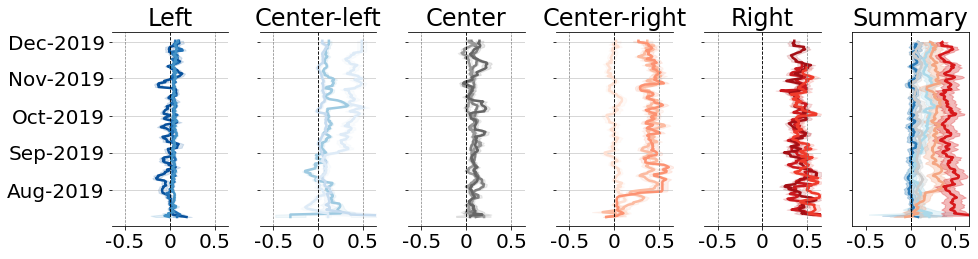

In [25]:
plt_helper.plot_vertical_scores(
    home_tl_df, 
    summary_xlim=[-.65,.65], 
    xlabel="M2 - URL (User timeline) score for the bots",
    filename=os.path.join(OUTPUT_PATH,"timeline_{}_{}.pdf".format(loc,medium))
);

[back to top](#top) <a id='user_timeline'></a>
## User Timeline Drift           
The political alignment score over time based of the content (URL and hashtag) **generated by** our accounts.

In [26]:
loc= "usr"

### Based on URL scores

In [27]:
medium = "url"
user_tl_df = plt_helper.load_data(
    medium, 
    loc, 
    center_score= get_central_score(medium), 
    basepath= os.path.join(DATA_PATH,"time_series/")
)
user_tl_df.head(2)

/nfs/nfs7/home/pacheco/code/DrifterBot/exps/plot_helper.py:289: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['bot%s%s' % (bot_idx, stat)] = tmp_df['bot%s%s' % (bot_idx, stat)].fillna(method='ffill')
/nfs/nfs7/home/pacheco/code/DrifterBot/exps/plot_helper.py:290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['bot%s%s' % (bot_idx, stat)] = tmp_df['bot%s%s' % (bot_idx, stat)].fillna(method='bfill')


,bot1,bot1_var,bot1_count,bot1_sem,bot2,bot2_var,bot2_count,bot2_sem,bot3,bot3_var,...,bot13_count,bot13_sem,bot14,bot14_var,bot14_count,bot14_sem,bot15,bot15_var,bot15_count,bot15_sem
date,,,,,,,,,,,,,,,,,,,,,
2019-07-11,-0.44025,0.061864,1.0,0.175875,-0.44025,0.043238,1.0,0.120052,-0.345383,0.048959,...,1.0,0.073033,0.3034,0.125952,1.0,0.25095,-0.3184,0.098851,1.0,0.181522
2019-07-12,-0.44025,0.061864,1.0,0.175875,-0.44025,0.043238,1.0,0.120052,-0.345383,0.048959,...,1.0,0.073033,0.3034,0.125952,1.0,0.25095,-0.3184,0.098851,1.0,0.181522


In [28]:
summary_results.append(("{}-{}".format(loc,medium),user_tl_df))

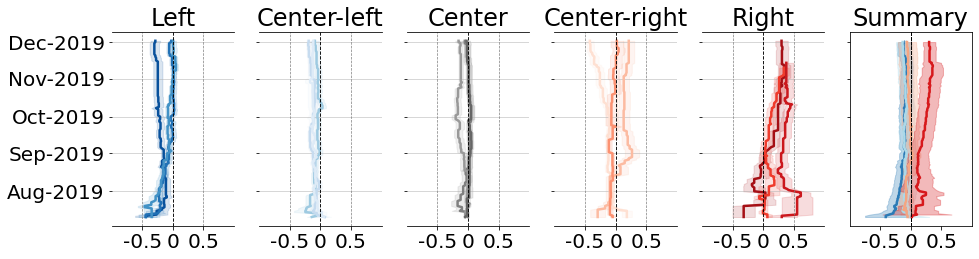

In [29]:
plt_helper.plot_vertical_scores(
    user_tl_df, 
    summary_xlim=[-1,1], 
    xlabel="",
    filename=os.path.join(OUTPUT_PATH,"timeline_{}_{}.pdf".format(loc,medium))
);

### Based on HASHTAG scores

In [30]:
medium = "hashtag"
user_tl_df = plt_helper.load_data(
    medium, 
    loc, 
    center_score= get_central_score(medium), 
    basepath= os.path.join(DATA_PATH,"time_series/")
)
user_tl_df.head(2)

/nfs/nfs7/home/pacheco/code/DrifterBot/exps/plot_helper.py:289: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['bot%s%s' % (bot_idx, stat)] = tmp_df['bot%s%s' % (bot_idx, stat)].fillna(method='ffill')
/nfs/nfs7/home/pacheco/code/DrifterBot/exps/plot_helper.py:290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['bot%s%s' % (bot_idx, stat)] = tmp_df['bot%s%s' % (bot_idx, stat)].fillna(method='bfill')


,bot1,bot1_var,bot1_count,bot1_sem,bot2,bot2_var,bot2_count,bot2_sem,bot3,bot3_var,...,bot13_count,bot13_sem,bot14,bot14_var,bot14_count,bot14_sem,bot15,bot15_var,bot15_count,bot15_sem
date,,,,,,,,,,,,,,,,,,,,,
2019-07-11,0.13363,0.101503,1.0,0.159298,0.115108,0.000061,1.0,0.005545,0.314424,0.090794,...,1.0,0.127975,-0.022912,0.014952,1.0,0.086465,-0.467401,0.232024,1.0,0.278103
2019-07-12,0.13363,0.101503,1.0,0.159298,0.115108,0.000061,1.0,0.005545,0.314424,0.090794,...,1.0,0.127975,-0.022912,0.014952,1.0,0.086465,-0.467401,0.232024,1.0,0.278103


In [31]:
summary_results.append(("{}-{}".format(loc,medium),user_tl_df))

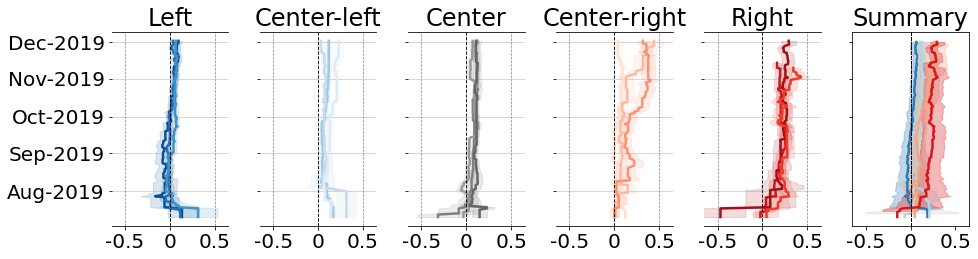

In [32]:
plt_helper.plot_vertical_scores(
    user_tl_df, 
    summary_xlim=[-.65,.65], 
    xlabel="",
    filename=os.path.join(OUTPUT_PATH,"timeline_{}_{}.pdf".format(loc,medium))
);

[back to top](#top) <a id='bias'></a>
## Algorithimic Bias
Checking whether or not the platform influence some sort of suppression or propaganda over the content generated by their users. We measure the difference between what the friends of one account generate (i.e., potential input - friends user timeline) and one's home timeline (i.e., real input).

In [33]:
loc= "friend_usr"

### Based on URL scores

In [34]:
medium = "url"
bias_tl_df = plt_helper.load_data_bias(
    medium, 
    basepath= os.path.join(DATA_PATH,"time_series/")
)
bias_tl_df.head(2)

/nfs/nfs7/home/pacheco/code/DrifterBot/exps/plot_helper.py:302: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  date_parser=lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
/nfs/nfs7/home/pacheco/code/DrifterBot/exps/plot_helper.py:317: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  date_parser=lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
/nfs/nfs7/home/pacheco/code/DrifterBot/exps/plot_helper.py:355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['bot%s%s' % (bot_idx, stat)] = tmp_df['bot%s%s' % (bot_idx, stat)].fillna(method='f

,bot1,bot1_sem,bot1_var,bot1_count,bot2,bot2_sem,bot2_var,bot2_count,bot3,bot3_sem,...,bot13_var,bot13_count,bot14,bot14_sem,bot14_var,bot14_count,bot15,bot15_sem,bot15_var,bot15_count
date,,,,,,,,,,,,,,,,,,,,,
2019-07-13,-0.405576,NaN,NaN,50.0,-0.464773,0.195889,0.073793,50.0,-0.018297,0.033187,...,0.065687,50.0,-0.012035,0.103949,0.049115,50.0,0.026295,0.118257,0.116538,50.0
2019-07-14,-0.039878,0.045295,0.042941,50.0,-0.464773,0.195889,0.073793,50.0,-0.018297,0.033187,...,0.131345,50.0,-0.012035,0.103949,0.049115,50.0,0.072850,0.089847,0.106843,50.0


In [35]:
summary_results.append(("{}-{}".format(loc,medium),bias_tl_df))

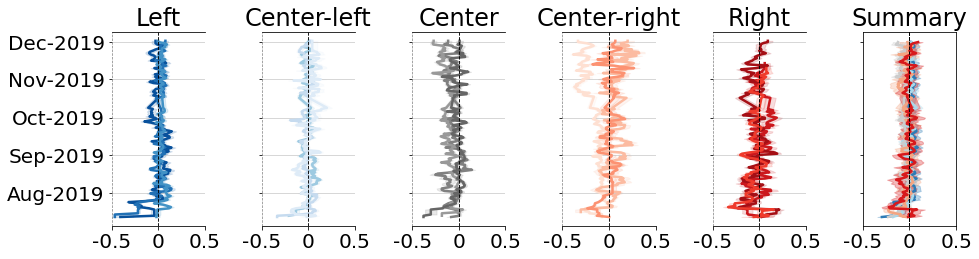

In [36]:
plt_helper.plot_vertical_scores(
    bias_tl_df, 
    summary_xlim=[-.5,.5], 
    xlabel="",
    filename=os.path.join(OUTPUT_PATH,"{}_bias.pdf".format(medium)),
);

### Based on HASHTAG scores

In [37]:
medium = "hashtag"
bias_tl_df = plt_helper.load_data_bias(
    medium, 
    basepath= os.path.join(DATA_PATH,"time_series/")
)
bias_tl_df.head(2)

/nfs/nfs7/home/pacheco/code/DrifterBot/exps/plot_helper.py:302: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  date_parser=lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
/nfs/nfs7/home/pacheco/code/DrifterBot/exps/plot_helper.py:317: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  date_parser=lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
/nfs/nfs7/home/pacheco/code/DrifterBot/exps/plot_helper.py:355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['bot%s%s' % (bot_idx, stat)] = tmp_df['bot%s%s' % (bot_idx, stat)].fillna(method='f

,bot1,bot1_sem,bot1_var,bot1_count,bot2,bot2_sem,bot2_var,bot2_count,bot3,bot3_sem,...,bot13_var,bot13_count,bot14,bot14_sem,bot14_var,bot14_count,bot15,bot15_sem,bot15_var,bot15_count
date,,,,,,,,,,,,,,,,,,,,,
2019-07-13,0.095316,0.053404,0.049640,28.0,0.081372,0.035378,0.027252,33.0,-0.207315,NaN,...,0.165788,28.0,-0.559798,NaN,NaN,26.0,-0.198266,NaN,NaN,16.0
2019-07-14,-0.002065,0.047257,0.062965,35.0,0.081372,0.035378,0.027252,33.0,-0.207315,NaN,...,0.152971,50.0,-0.559798,NaN,NaN,26.0,0.025947,0.107916,0.183005,22.0


In [38]:
summary_results.append(("{}-{}".format(loc,medium),bias_tl_df))

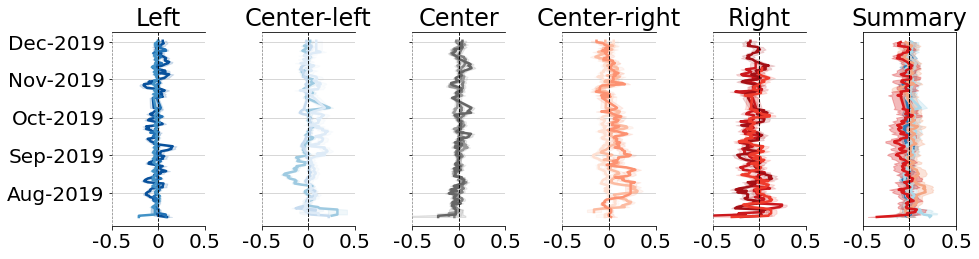

In [39]:
ax = plt_helper.plot_vertical_scores(
    bias_tl_df, 
    summary_xlim=[-.5,.5], 
    xlabel="",
    filename=os.path.join(OUTPUT_PATH,"{}_bias.pdf".format(medium)),
);

[back to top](#top) <a id='summary'></a>
## Drifter Summary
This plot shows the summary of the home timeline, friend's timeline, and algorithimc bias.

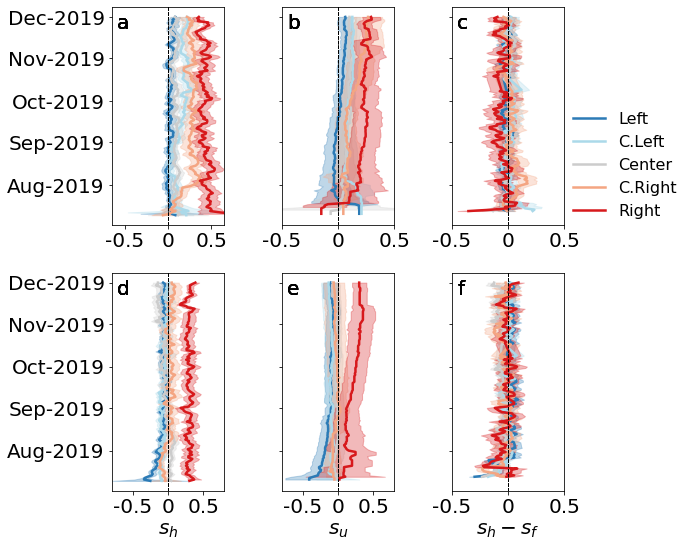

In [40]:
axs = plt_helper.plot_vertical_scores_summary(
    summary_results[1][1], # home timeline
    summary_results[3][1], # friends user timeline
    summary_results[5][1], # algorithmic bias
    summary_results[0][1], # home timeline
    summary_results[2][1], # friends user timeline
    summary_results[4][1], # algorithmic bias
    figsize=(10,8),
    home_tl_xlim=.65, friends_xlim=.5, bias_xlim=.5,
    home_tl_xlim2=.8, friends_xlim2=.8, bias_xlim2=.5,
    filename=os.path.join(OUTPUT_PATH,"drifter_summary_{}.pdf".format("all")),
    
)
